# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
!python --version

Python 3.11.11


In [3]:
pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.0

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sklearn
import imblearn

print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn.__version__)

scikit-learn version: 1.2.2
imbalanced-learn version: 0.10.0


# Exploratory Data Analysis

In [5]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Dataset Preprocessing

In [6]:
X = df.drop(columns=['Class', 'Time'])  # Drop 'Time'
y = df['Class']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
from imblearn.over_sampling import SMOTE
import pandas as pd

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_smote).value_counts().to_dict())

Before SMOTE: {0: 213236, 1: 369}
After SMOTE: {0: 213236, 1: 213236}


In [10]:
import joblib
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# SMOTE+GridSearchCV

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

model_metrics = {}

def evaluate_model(y_true, y_pred, y_proba, model_name, model, X):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    model_metrics[model_name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC AUC': auc
    }

    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_proba, name=model_name)
    plt.title(f'ROC Curve - {model_name}')
    plt.show()

    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        pd.Series(model.feature_importances_, index=X.columns).sort_values().plot.barh()
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()



Random Forest Metrics:
Accuracy: 0.9995, Precision: 0.8571, Recall: 0.8293, F1: 0.8430, AUC: 0.9834


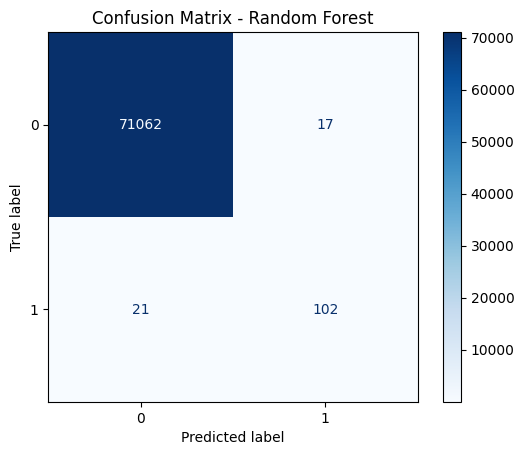

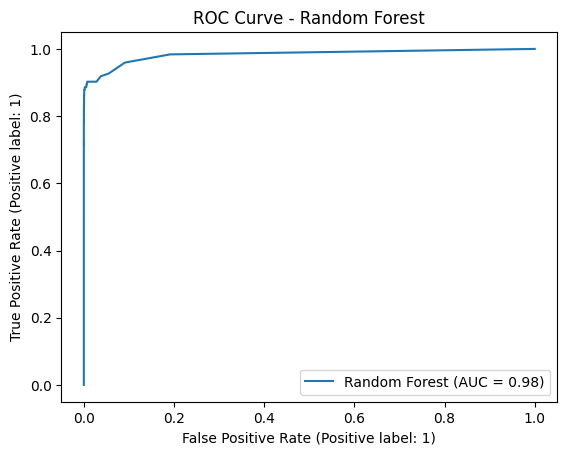

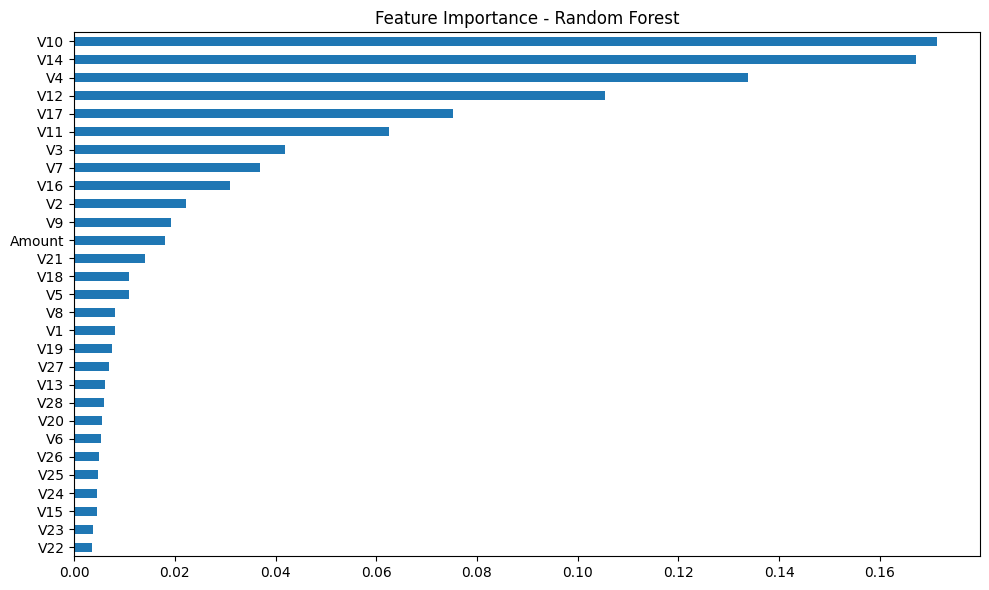

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid=params_rf, scoring='roc_auc', cv=3, n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)

best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred, y_proba, "Random Forest", best_rf, pd.DataFrame(X_train))


In [17]:
import joblib

joblib.dump(best_rf, 'best_model.joblib')  # Save the best model

['best_model.joblib']